In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **Reading CSV**

In [2]:
start_time = time.time()
fraud = pd.read_csv('/content/drive/MyDrive/Accredian/Fraud.csv')

In [3]:
fraud2 = pd.read_csv('/content/drive/MyDrive/Accredian/Fraud.csv')

In [4]:
# Set the display format for float values
pd.options.display.float_format = '{:.2f}'.format

# Display summary statistics of the fraud DataFrame
fraud_description = fraud.describe()

# Print or display the summary statistics
print(fraud_description)

            step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count 1048575.00  1048575.00     1048575.00      1048575.00      1048575.00   
mean       26.97   158666.98      874009.54       893808.90       978160.05   
std        15.62   264940.93     2971750.56      3008271.33      2296780.39   
min         1.00        0.10           0.00            0.00            0.00   
25%        15.00    12149.07           0.00            0.00            0.00   
50%        20.00    76343.33       16002.00            0.00       126377.21   
75%        39.00   213761.89      136642.02       174599.99       915923.47   
max        95.00 10000000.00    38900000.00     38900000.00     42100000.00   

       newbalanceDest    isFraud  isFlaggedFraud  
count      1048575.00 1048575.00      1048575.00  
mean       1114197.97       0.00            0.00  
std        2416593.12       0.03            0.00  
min              0.00       0.00            0.00  
25%              0.00       0.00 

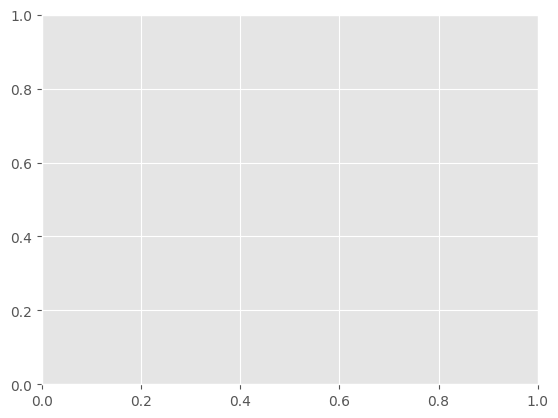

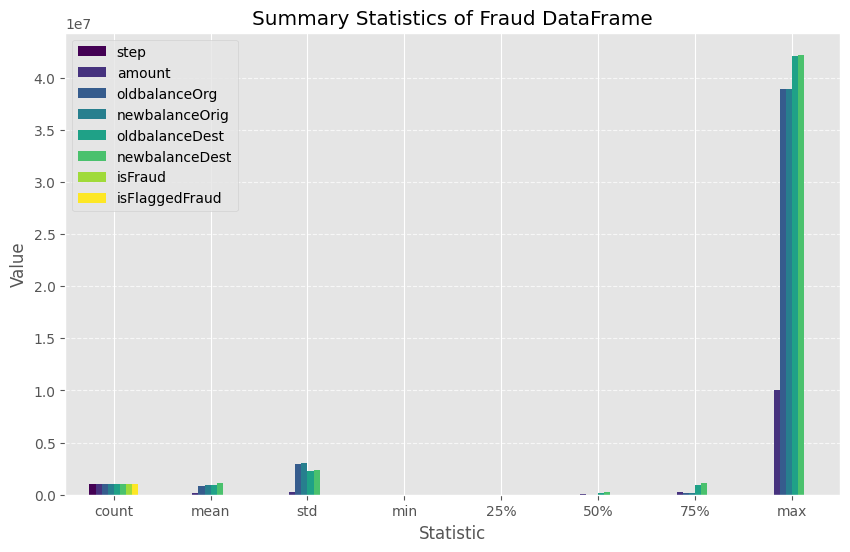

In [5]:
# Plotting the describe() output with values in exponential notation
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fraud.describe().plot(kind='bar', figsize=(10, 6), colormap='viridis', legend=True)
plt.title('Summary Statistics of Fraud DataFrame')
plt.ylabel('Value')
plt.xlabel('Statistic')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

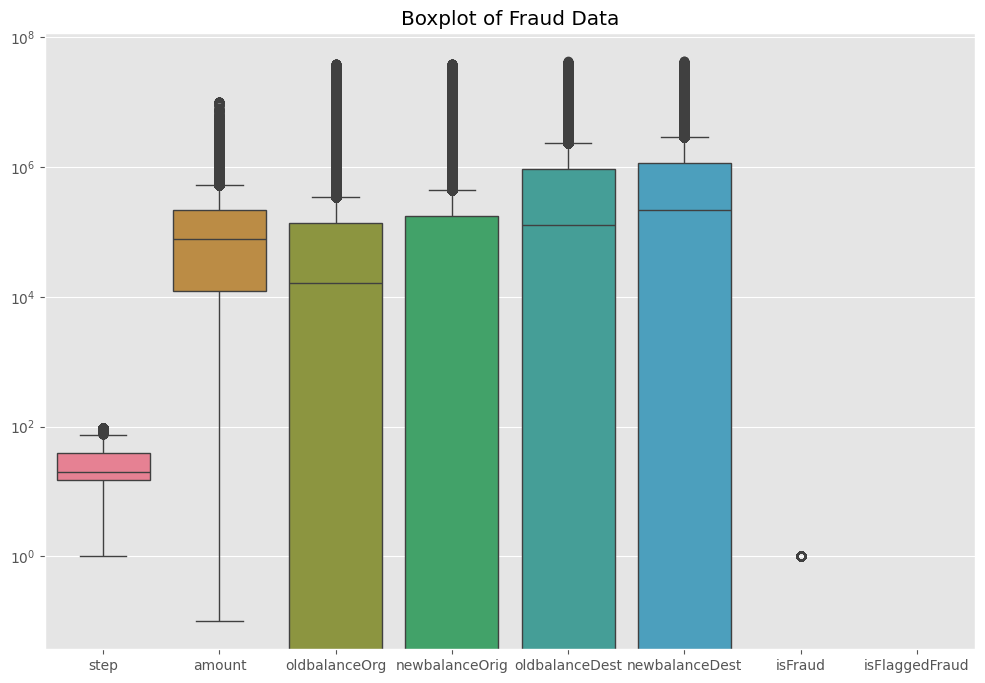

In [6]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Boxplotting with logarithmic y-axis scale
sns.boxplot(data=fraud)
plt.yscale('log')  # Set y-axis scale to logarithmic

# Set plot title
plt.title('Boxplot of Fraud Data')
plt.savefig('Boxplot')
# Show plot
plt.show()

In [7]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [8]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [9]:
fraud.shape

(1048575, 11)

# **Data Cleaning**

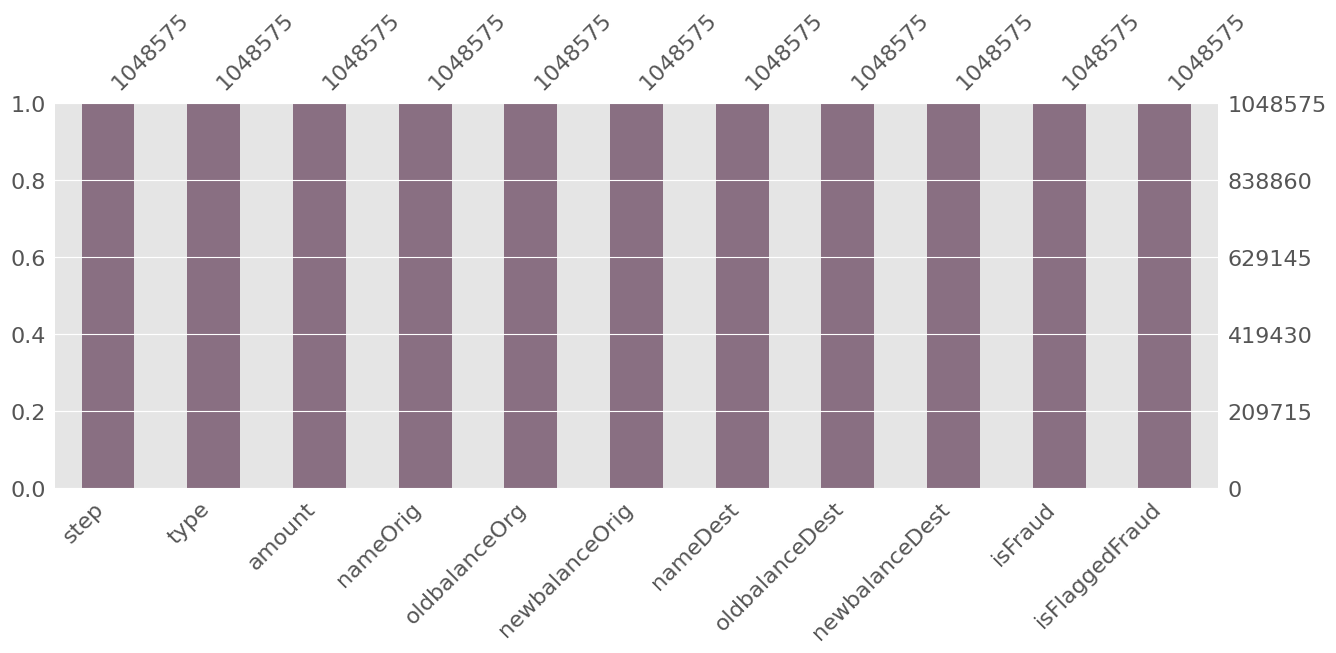

In [10]:
plt.figure(figsize = (15, 8))
msno.bar(fraud, figsize = (15,5), sort = 'ascending', color = "#896F82")
plt.show()

<Axes: >

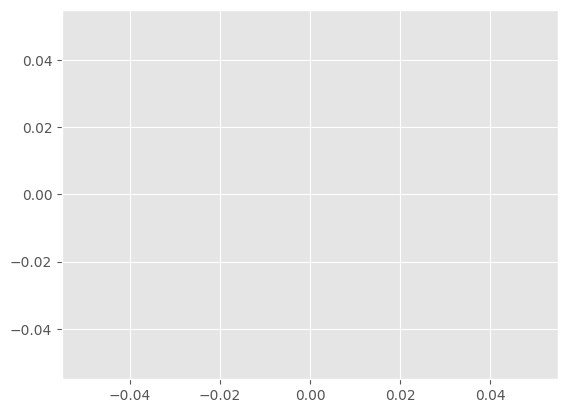

In [11]:
sns.distplot()

In [12]:
print('Number of duplicates are : ', fraud.duplicated().sum())

Number of duplicates are :  0


In [13]:
fraud.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [14]:
fraud = fraud.rename(columns = {'nameOrig' : 'origin', 'oldbalanceOrg' : 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'destination', 'oldbalanceDest' : 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance', 'isFraud' : 'isfraud'})

In [15]:
fraud = fraud.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

In [16]:
cols = fraud.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('destination')))
fraud = fraud[cols]

In [17]:
fraud.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,C1305486145,C553264065,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,C840083671,C38997010,181.00,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.00,29885.86,0.00,0.00,0


In [18]:
fraud2 = pd.read_csv('/content/drive/MyDrive/Accredian/Fraud.csv')
# Filter the dataset to include only rows where 'isFraud' is equal to 1
fraud_testing = fraud2[fraud2['isFraud'] == 1].copy()

# Display the first few rows of the testing dataset
print(fraud_testing.head())

     step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2       1  TRANSFER   181.00  C1305486145         181.00            0.00   
3       1  CASH_OUT   181.00   C840083671         181.00            0.00   
251     1  TRANSFER  2806.00  C1420196421        2806.00            0.00   
252     1  CASH_OUT  2806.00  C2101527076        2806.00            0.00   
680     1  TRANSFER 20128.00   C137533655       20128.00            0.00   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2     C553264065            0.00            0.00        1               0  
3      C38997010        21182.00            0.00        1               0  
251   C972765878            0.00            0.00        1               0  
252  C1007251739        26202.00            0.00        1               0  
680  C1848415041            0.00            0.00        1               0  


# ***Exploratory Data Analysis***

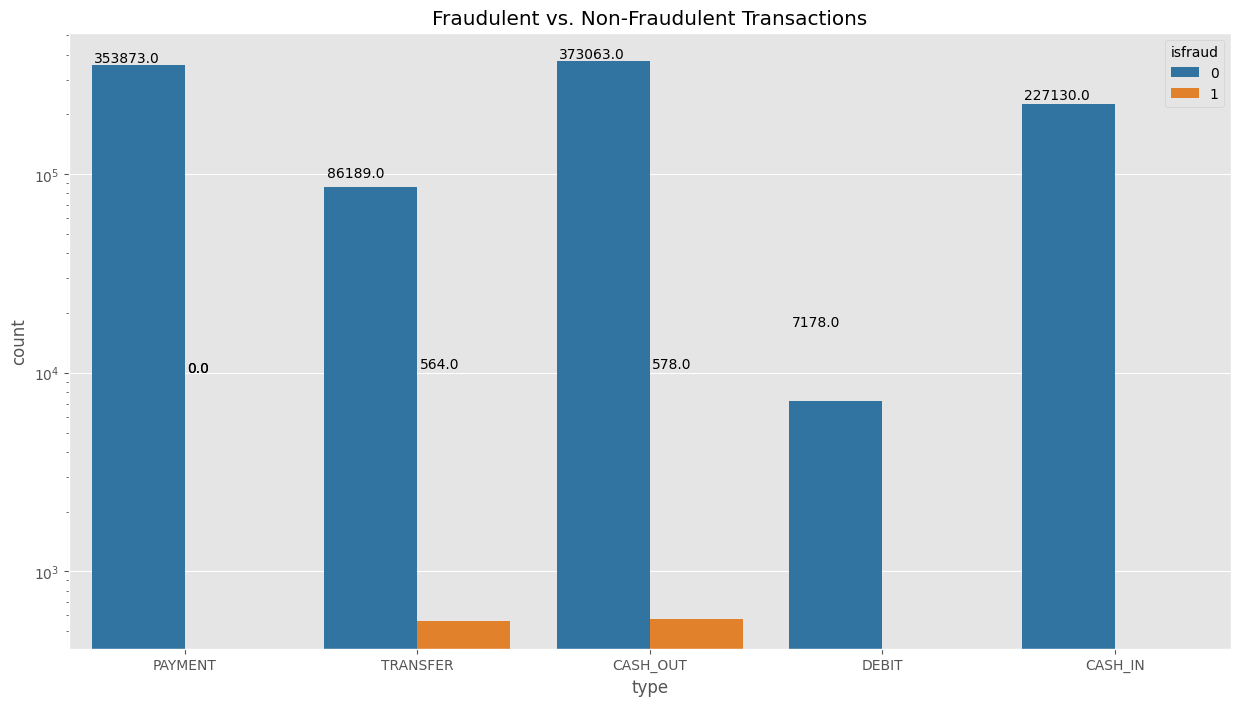

In [19]:
# Define custom colors
custom_palette = ['#1f77b4', '#ff7f0e']  # Blue and orange

plt.figure(figsize=(15, 8))
ax = sns.countplot(data=fraud, x="type", hue="isfraud", palette=custom_palette)
plt.yscale('log')  # Use log scale for y-axis
plt.title('Fraudulent vs. Non-Fraudulent Transactions')

# Adding annotations
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.01, p.get_height() + 10000))
plt.savefig('fraud_transactions_plot.png')
plt.show()

In [20]:
plt.savefig('fraud_transactions_plot.png')

<Figure size 640x480 with 0 Axes>

In [21]:
transfer_fraud = fraud[((fraud['type']=='TRANSFER') & fraud['isfraud']==1)]
transfer_fraud['origin'].value_counts()

origin
C1305486145    1
C920552627     1
C1198248537    1
C1422133318    1
C1116093088    1
              ..
C321662798     1
C2035691205    1
C722855847     1
C2112073607    1
C927181710     1
Name: count, Length: 564, dtype: int64

In [22]:
cash_out_fraud = fraud[(fraud['type'] == 'CASH_OUT') & (fraud['isfraud'] == 1)]
cash_out_fraud['destination'].value_counts()

destination
C803116137     2
C200064275     2
C185805228     2
C1981613973    2
C1013511446    2
              ..
C90854025      1
C373339841     1
C1009901500    1
C511164301     1
C1827219533    1
Name: count, Length: 573, dtype: int64

In [23]:
fraud_trans = fraud[fraud['isfraud'] == 1]
valid_trans = fraud[fraud['isfraud'] == 0]

trans_transfer = fraud[fraud['type'] == 'TRANSER']
trans_cashout = fraud[fraud['type'] == 'CASH_OUT']

print('Has the receiving accoung used for cashing out?')
trans_transfer.destination.isin(trans_cashout.origin).any()

Has the receiving accoung used for cashing out?


False

# **Feature Engineering**

In [24]:
data = fraud.copy()
data['type2'] = np.nan
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('C'), 'type2'] = 'CC'
data.loc[fraud.origin.str.contains('C') & fraud.destination.str.contains('M'), 'type2'] = 'CM'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MC'
data.loc[fraud.origin.str.contains('M') & fraud.destination.str.contains('C'), 'type2'] = 'MM'

In [25]:
cols = data.columns.tolist()
new_position = 1

cols.insert(new_position, cols.pop(cols.index('type2')))
data = data[cols]

In [26]:
data.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)

In [27]:
data.head()

,type,type2,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,CM,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,CM,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,CC,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,CC,181.00,181.00,0.00,21182.00,0.00,1
4,PAYMENT,CM,11668.14,41554.00,29885.86,0.00,0.00,0


In [28]:
fraud_trans = data[data['isfraud'] == 1]
valid_trans = data[data['isfraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 type2
CC    1142
Name: count, dtype: int64 

Number of valid transactions according to type are below:
 type2
CC    693560
CM    353873
Name: count, dtype: int64


# **Data Visualization**

In [29]:
fr = fraud_trans.type2.value_counts()
va = valid_trans.type2.value_counts()

Text(0.5, 1.0, 'Valid')

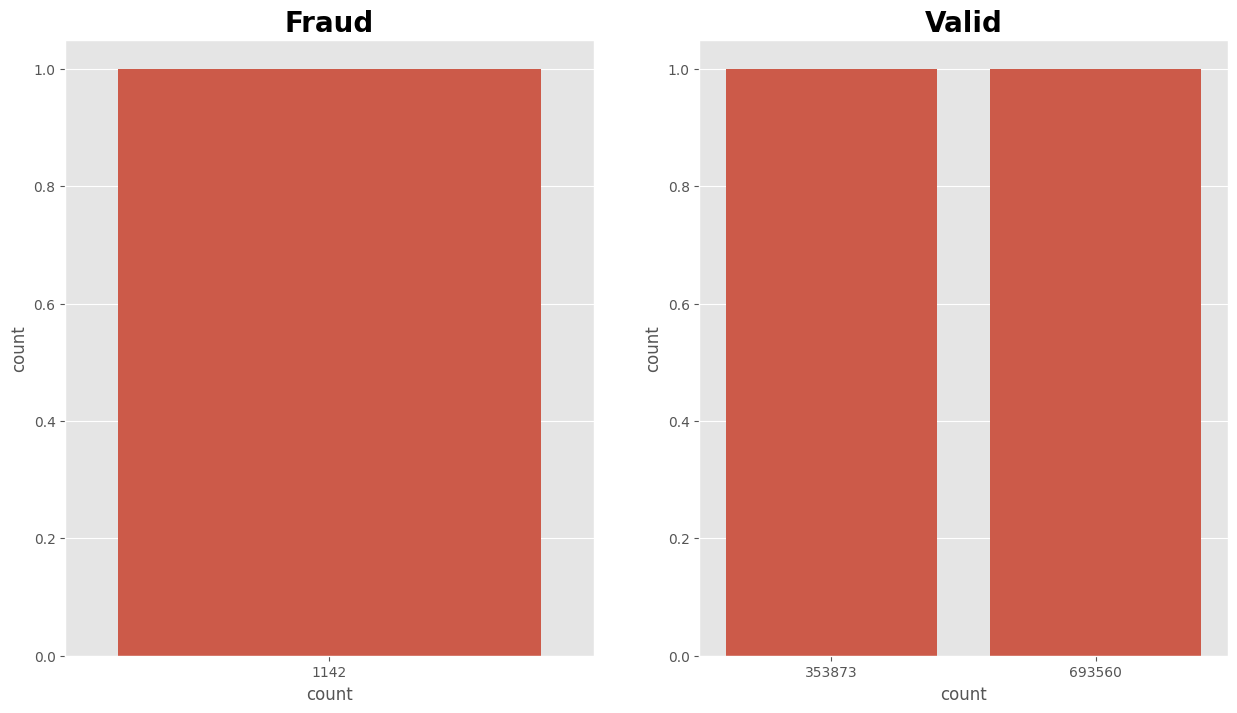

In [30]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.countplot(x = fr)
plt.title('Fraud',fontweight="bold", size=20)
plt.subplot(1,2,2)
sns.countplot(x = va)
plt.title('Valid',fontweight="bold", size=20)

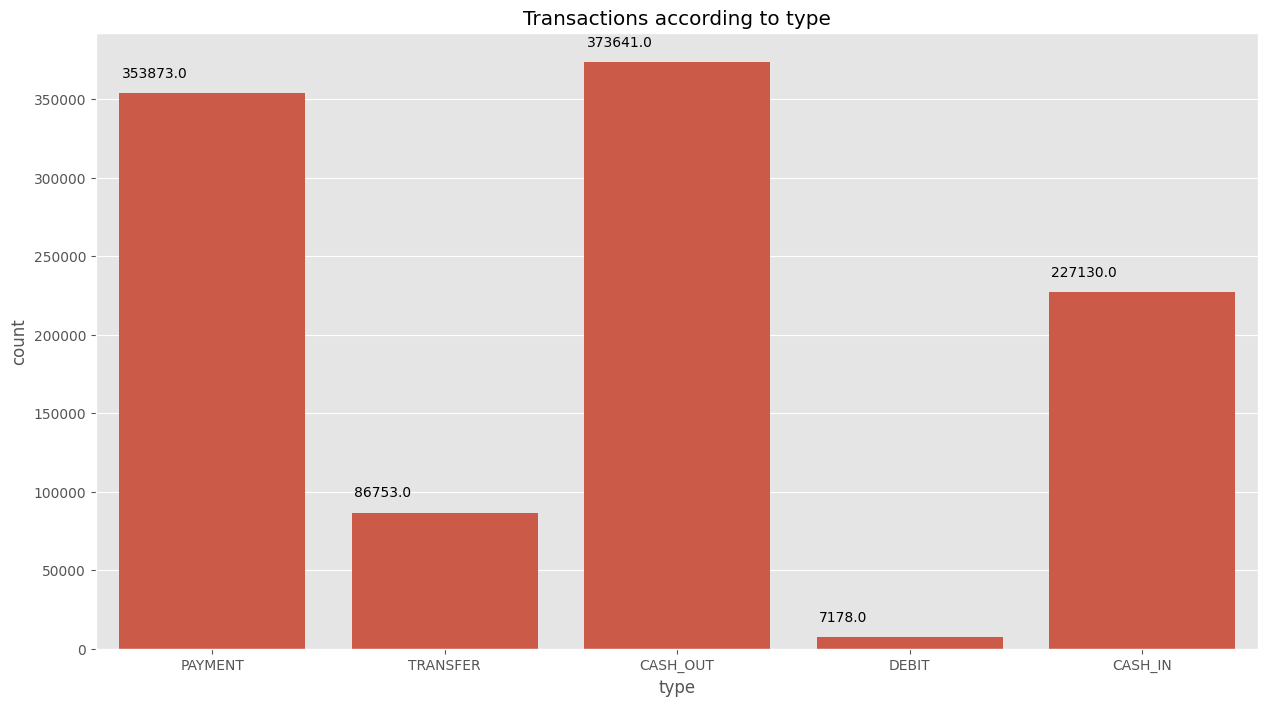

In [31]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type")
plt.title('Transactions according to type')
plt.savefig("Transactions according to Type")
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

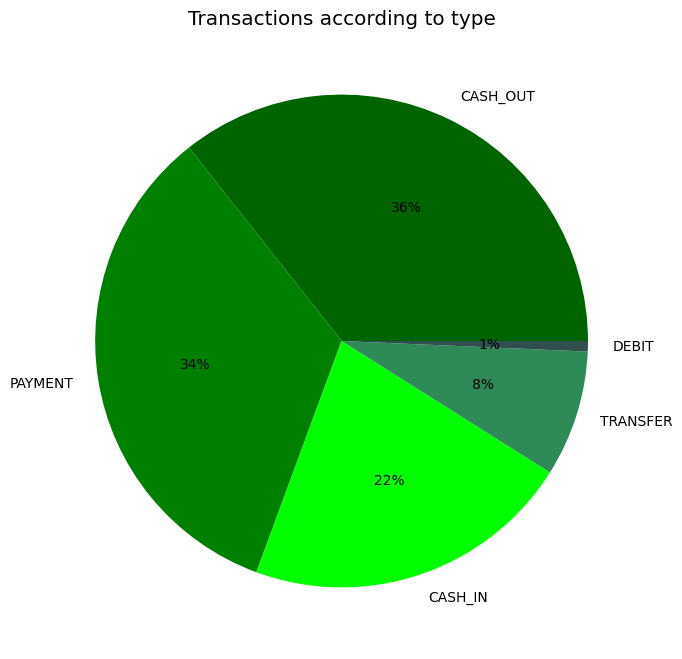

In [32]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000','#00FF00','#2E8B57','#2F4F4F']
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("Transactions according to type")
plt.savefig("Transactions according to type")
plt.show()

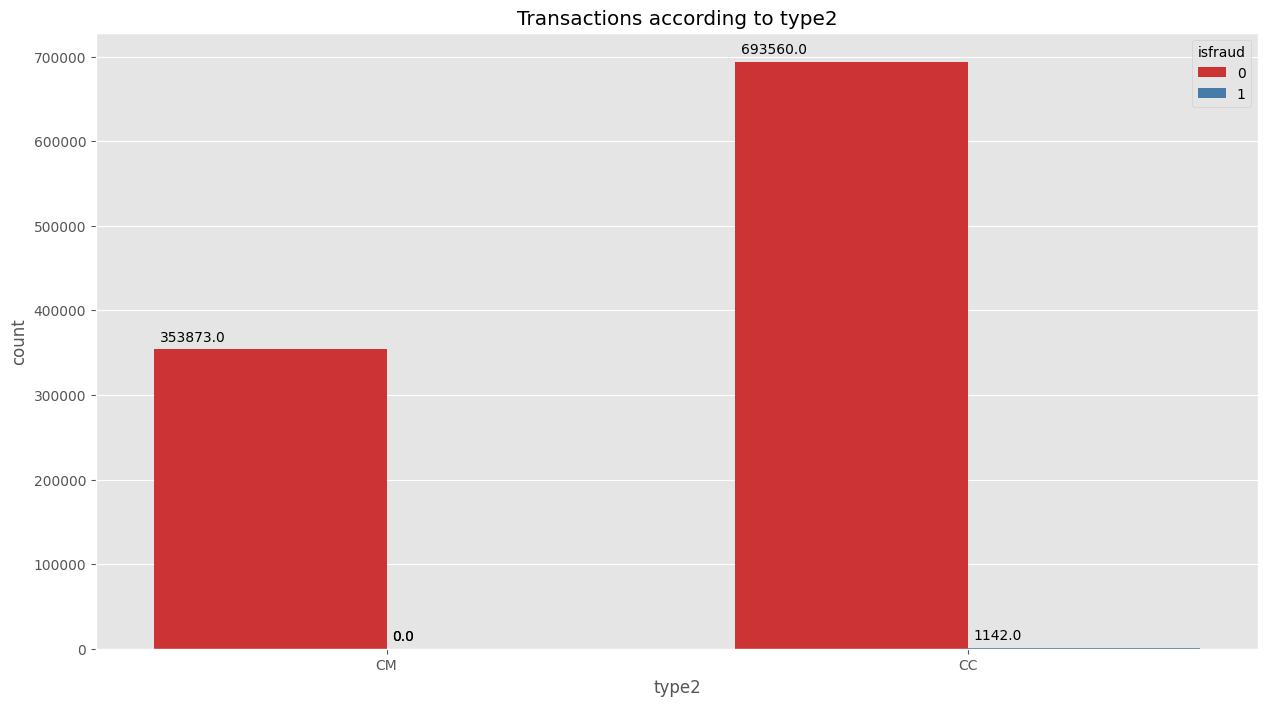

In [33]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data, x = "type2", hue="isfraud", palette = 'Set1')
plt.title('Transactions according to type2')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

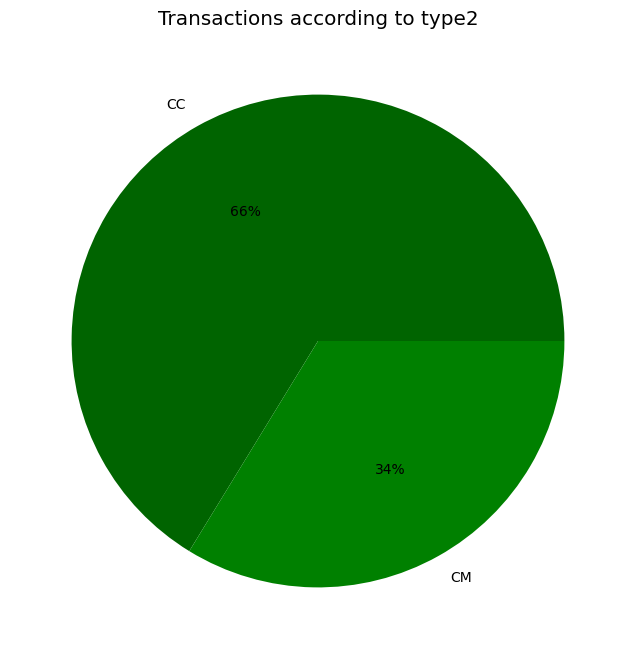

In [34]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000']
plt.pie(data.type2.value_counts().values,labels=data.type2.value_counts().index, colors = colors,  autopct='%.0f%%')
plt.title("Transactions according to type2")
plt.show()

# **Data Preprocessing**

In [35]:
data = pd.get_dummies(data, prefix = ['type', 'type2'], drop_first = True)

In [36]:
X = data.drop('isfraud',axis=1)
y = data.isfraud

In [37]:
for i in range(5):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = data.isfraud)
    end_time = time.time()

    execution_time = end_time - start_time
    print("Time taken to train test split:", execution_time, "seconds")

Time taken to train test split: 0.9400243759155273 seconds
Time taken to train test split: 0.9928410053253174 seconds
Time taken to train test split: 0.9226198196411133 seconds
Time taken to train test split: 0.7415399551391602 seconds
Time taken to train test split: 0.5545792579650879 seconds


In [38]:
print(len(X_train))

734002


In [39]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# **Model Building**

In [40]:
X.head()

,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CM
0,9839.64,170136.00,160296.36,0.00,0.00,False,False,True,False,True
1,1864.28,21249.00,19384.72,0.00,0.00,False,False,True,False,True
2,181.00,181.00,0.00,0.00,0.00,False,False,False,True,False
3,181.00,181.00,0.00,21182.00,0.00,True,False,False,False,False
4,11668.14,41554.00,29885.86,0.00,0.00,False,False,True,False,True


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Configure RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, max_depth=5)

# Configure DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=5)

# Configure LogisticRegression
logreg = LogisticRegression(max_iter=100, penalty='l2', solver='lbfgs')

# Configure GaussianNB
nb = GaussianNB()

# Fit the models
rfc.fit(X_train, y_train)
dtc.fit(X_train, y_train)
logreg.fit(X_train, y_train)
nb.fit(X_train, y_train)

# Store the models in a list
classifiers = [rfc, dtc, logreg, nb]

In [42]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

accuracy_list = []
auc_list = []
precision_list = []
recall_list = []

for classifier in classifiers:
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))

In [43]:
metrics_dict = {
    'accuracy': accuracy_list,
    'auc': auc_list,
    'precision': precision_list,
    'recall': recall_list
}

metrics_dict_sorted = {}
for metric, values in metrics_dict.items():
    sorted_values = [values[i] for i in sorted(range(len(classifiers)), key=lambda k: values[k])]
    metrics_dict_sorted[metric] = sorted_values

# Transposing the dictionaries
classifiers_names = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'Naive Bayes']
transposed_metrics = {classifier: [] for classifier in classifiers_names}
for metric, values in metrics_dict.items():
    for i, classifier in enumerate(classifiers_names):
        transposed_metrics[classifier].append(values[i])

# Printing the metrics grouped by model
for classifier, values in transposed_metrics.items():
    print(f'{classifier}:')
    for metric, value in zip(['auc'], values):
        print(f'{metric}: {value}')
    print()

Random Forest:
auc: 0.9993197127534785

Decision Tree:
auc: 0.9994945529336593

Logistic Regression:
auc: 0.9991830195217009

Naive Bayes:
auc: 0.4384133412594215



In [44]:
from sklearn.metrics import roc_auc_score

auc_per_class = {}

for classifier in classifiers:
    y_pred_proba = classifier.predict_proba(X_test)
    classes = classifier.classes_
    auc_per_class[classifier.__class__.__name__] = {}
    for i, class_name in enumerate(classes):
        auc_per_class[classifier.__class__.__name__][class_name] = roc_auc_score(y_test == class_name, y_pred_proba[:, i])

# Printing the AUC for each class in each model
for model, class_aucs in auc_per_class.items():
    print(model)
    for class_name, auc in class_aucs.items():
        print(f'Class {class_name}: AUC = {auc}')
    print()

RandomForestClassifier
Class 0: AUC = 0.9803855024763666
Class 1: AUC = 0.9803855024763667

DecisionTreeClassifier
Class 0: AUC = 0.8226272765051392
Class 1: AUC = 0.8226272765051392

LogisticRegression
Class 0: AUC = 0.960952790425093
Class 1: AUC = 0.960952790425093

GaussianNB
Class 0: AUC = 0.9188764446090584
Class 1: AUC = 0.9174891671427097



In [45]:
from sklearn.metrics import classification_report, accuracy_score

for classifier in classifiers:
    y_pred = classifier.predict(X_test)
    print(classifier.__class__.__name__)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print()

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.99      0.38      0.55       343

    accuracy                           1.00    314573
   macro avg       1.00      0.69      0.77    314573
weighted avg       1.00      1.00      1.00    314573

Accuracy: 0.9993197127534785

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.92      0.59      0.72       343

    accuracy                           1.00    314573
   macro avg       0.96      0.79      0.86    314573
weighted avg       1.00      1.00      1.00    314573

Accuracy: 0.9994945529336593

LogisticRegression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314230
           1       0.90      0.28      0.43       343

    accuracy                           1.00    314573
   

In [59]:
def px_bar(x,y,text,title,color,color_discrete_sequence):
    return px.bar(x = x, y = y, text = text, title = title, color = color, color_discrete_sequence=color_discrete_sequence)

In [60]:
fig = px_bar(list(metrics_dict_sorted.keys()), list(metrics_dict_sorted['accuracy']), np.round(list(metrics_dict_sorted['accuracy']),3), 'Accuracy score of each classifiers', list(metrics_dict_sorted.keys()), px.colors.sequential.matter)
for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

In [62]:
fig = px_bar(list(metrics_dict_sorted.keys()), list(metrics_dict_sorted['accuracy']), np.round(list(metrics_dict_sorted['accuracy']),3), 'Accuracy score of each classifiers', list(metrics_dict_sorted.keys()), px.colors.sequential.matter)

for idx in [2,3]:
    fig.data[idx].marker.line.width = 3
    fig.data[idx].marker.line.color = "black"
fig.show()

# **Model Evaluation**

In [63]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)[:,1]

In [64]:
print(classification_report(y_test, rfc_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    314230
       Fraud       0.97      0.69      0.81       343

    accuracy                           1.00    314573
   macro avg       0.99      0.85      0.90    314573
weighted avg       1.00      1.00      1.00    314573



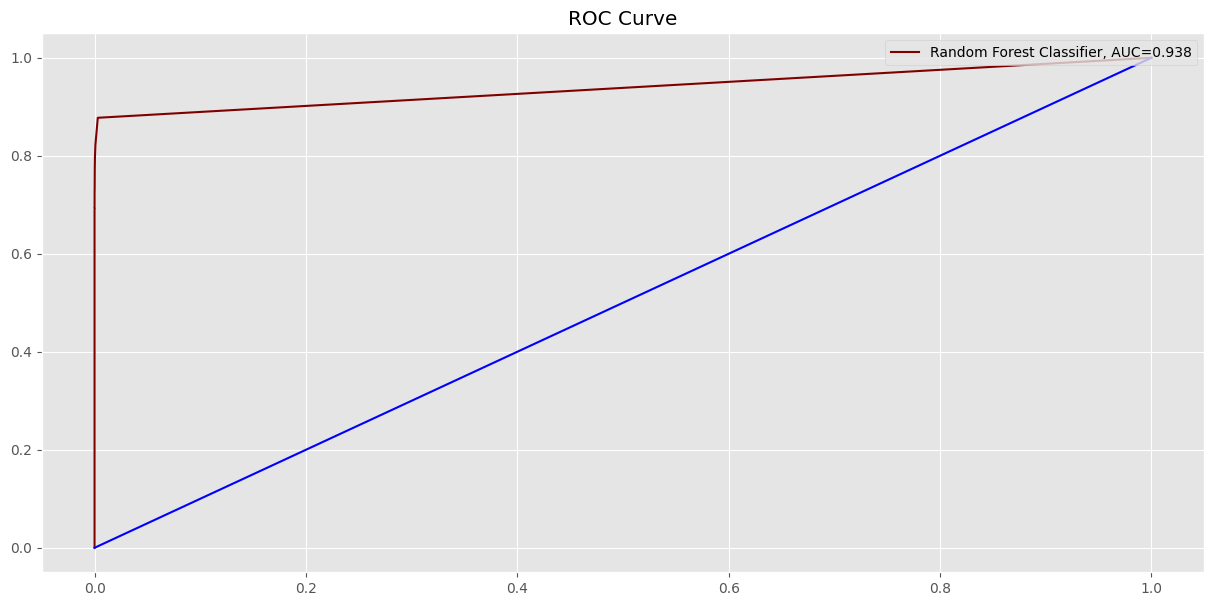

In [68]:
fpr, tpr, temp = roc_curve(y_test, rfc_pred_proba)
auc = round(roc_auc_score(y_test, rfc_pred_proba),3)
plt.figure(figsize=(15,7))
plt.plot(fpr,tpr,label='Random Forest Classifier, AUC='+str(auc),linestyle='solid',color='#800000')
plt.plot([0, 1], [0, 1], color = 'b')
plt.title('ROC Curve')
plt.legend(loc='upper right')